In [38]:
import os
import xgboost
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from pytorch_tabnet.tab_model import TabNetClassifier

In [13]:
df = pd.read_csv("train.csv", header=None)
label = pd.read_csv("trainLabels.csv", header=None)
print("Size of feature: {}\nSize of label: {}".format(df.shape, label.shape))

Size of feature: (1000, 40)
Size of label: (1000, 1)


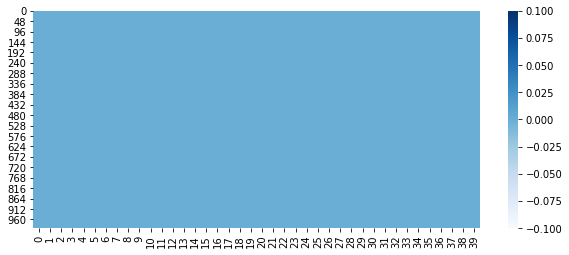

In [14]:
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cmap="Blues")
plt.show()

In [16]:
df = StandardScaler().fit_transform(df)
x_train, x_test, y_train, y_test = train_test_split(df, label.values.ravel(), test_size=0.25, random_state=17)

In [6]:
clf = xgboost.XGBClassifier(random_state=17)
n_estimators = [int(x) for x in np.linspace(100, 1000, 10)]
max_depth = [int(x) for x in np.linspace(5, 15, 10)]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
grid_search = GridSearchCV(clf, param_grid, scoring="accuracy", n_jobs=-1, verbose=0)
grid_result = grid_search.fit(x_train, y_train)
print("Best Accuracy: %.4f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.8893 using {'max_depth': 6, 'n_estimators': 200}


C:\Users\YangWang\Anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\YangWang\Anaconda3\envs\nlp\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


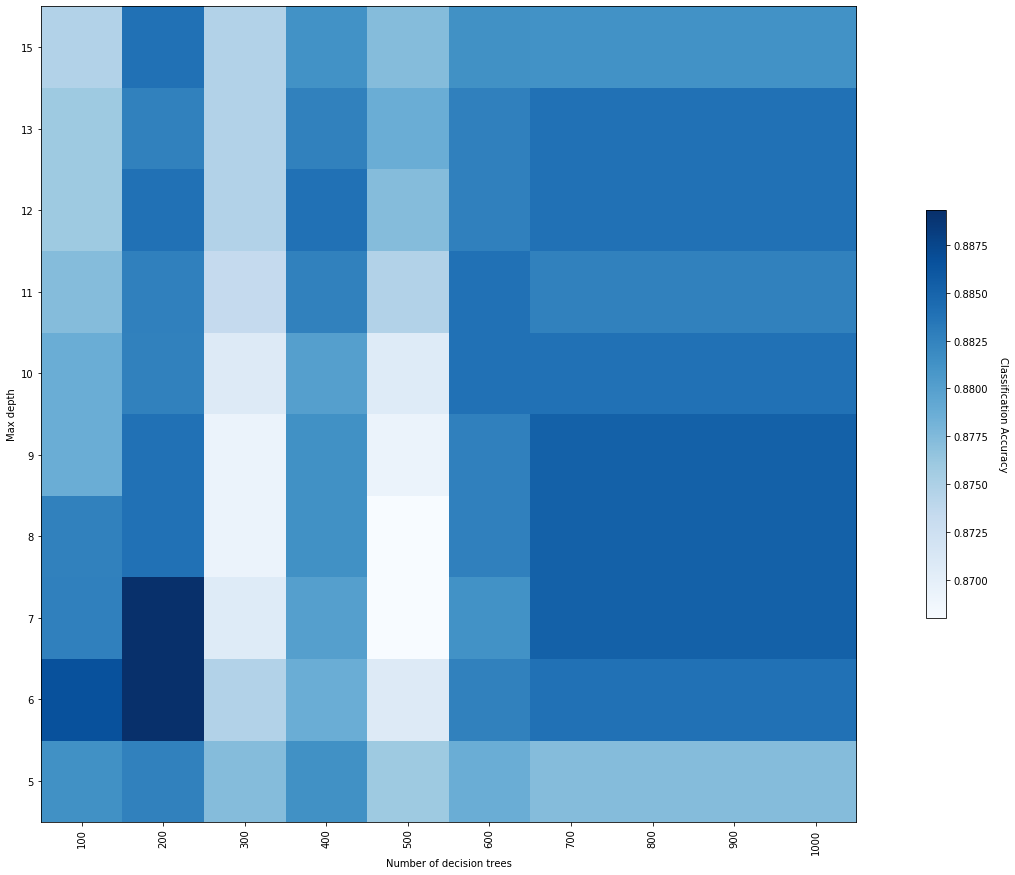

In [7]:
# Reference from 
# https://cambridgecoding.wordpress.com/2016/04/03/scanning-hyperspace-how-to-tune-machine-learning-models/
import matplotlib.pyplot as plt
%matplotlib inline
 
# Fetch scores, reshape into a grid
scores = [x for x in grid_result.cv_results_.get("mean_test_score")]
scores = np.array(scores).reshape(len(n_estimators), len(max_depth))
scores = np.transpose(scores)
 
# Make heatmap from grid search results
plt.figure(figsize=(25, 15))
plt.imshow(scores, interpolation='nearest', origin='higher', cmap='Blues')
plt.xticks(np.arange(len(n_estimators)), n_estimators)
plt.yticks(np.arange(len(max_depth)), max_depth)
plt.xlabel('Number of decision trees')
plt.ylabel('Max depth')
plt.xticks(rotation=90)
plt.colorbar(shrink=0.5).set_label('Classification Accuracy', rotation=270, labelpad=20)
plt.show()

In [8]:
# Train again using the best hyperparameters
clf_bestparam = xgboost.XGBClassifier(
    max_depth=grid_result.best_params_['max_depth'], 
    n_estimators=grid_result.best_params_['n_estimators'], 
    random_state=17)
clf_bestparam.fit(x_train, y_train)
y_pred = clf_bestparam.predict(x_test)
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))

Accuracy: 0.8200


In [10]:
x_test = pd.read_csv("test.csv", header=None)
x_test = StandardScaler().fit_transform(x_test)
y_pred = clf_bestparam.predict(x_test)
submit = pd.DataFrame(y_pred)
submit.index += 1
submit.columns = ['Solution']
submit['Id'] = np.arange(1, submit.shape[0]+1)
submit = submit[['Id', 'Solution']]
submit.to_csv('Submission.csv', index=False)

In [11]:
class TabNetTuner(TabNetClassifier):
    def fit(self, X, y, *args, **kwargs):
        self.n_d = self.n_a
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.2, 
            random_state=0, 
            shuffle=True, 
            stratify=y)
        
        return super().fit(
            X_train,y_train,
            patience=3,
            X_valid=X_valid,y_valid=y_valid,
            num_workers=os.cpu_count(),max_epochs=10, 
            batch_size=2048, virtual_batch_size=512)

In [40]:
feature = pd.read_csv("train.csv", header=None)
label = pd.read_csv("trainLabels.csv", header=None)
label.columns = ["target"]
train = pd.concat([feature, label], axis=1)

Fold = KFold(n_splits=5, shuffle=True, random_state=17)
for n, (train_index, val_index) in enumerate(Fold.split(train, train["target"])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)

if "Set" not in train.columns:
    train["Set"] = np.random.choice(
        ["train", "valid"], p=[0.8, 0.2], size=(train.shape[0],))
    
train_indices = train.loc[train.Set == "train"].index
valid_indices = train.loc[train.Set == "valid"].index

# Define tuner
tb = TabNetTuner()

# Define param
grid = {
    "n_a": [16, 32],
    "n_independent": [3, 4, 5],
    "n_shared": [1, 2], 
    "n_steps": [3, 5],
    "clip_value": [1.],
    "gamma": [0.5, 2.],
    "momentum": [0.1, 0.005],
    "lambda_sparse": [0.1, 0.01],
    "lr": [0.1, 0.02],
    "verbose": [1]}

# Define searching object
rand_search = RandomizedSearchCV(
    tb, grid, n_iter=5,
    scoring="accuracy", n_jobs=1,
    refit=False,
    cv=[(train_indices, valid_indices)],
    verbose=1, pre_dispatch=0,
    random_state=42,
    return_train_score=False)

Device used : cuda


In [41]:
# get relevant features
features = list(set(train.columns.tolist()) - set(['target']) - set(["Set"]) - set(['fold']))

label = ['target']

X = train[features].values
y = train[label].values.squeeze(1)

print(features, X.shape)
print(label, y.shape)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39] (1000, 40)
['target'] (1000,)


In [42]:
rand_search.fit(X, y)
rand_search.best_params_

Device used : cuda
Fitting 1 folds for each of 5 candidates, totalling 5 fits
Device used : cuda
Will train until validation stopping metric hasn't improved in 3 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


| 1     | 0.57943 |  0.61562 |   11.8      
| 2     | 0.62916 |  0.54211 |   23.5      
| 3     | 0.66160 |  0.54720 |   35.2      
| 4     | 0.68183 |  0.52294 |   46.9      
Early stopping occured at epoch 4
Training done in 46.901 seconds.
---------------------------------------
Device used : cuda
Will train until validation stopping metric hasn't improved in 3 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.52056 |  0.42895 |   11.9      
| 2     | 0.55262 |  0.57253 |   23.7      
| 3     | 0.57699 |  0.51168 |   35.5      
| 4     | 0.66311 |  0.58322 |   47.3      
| 5     | 0.65293 |  0.62056 |   59.2      
| 6     | 0.71550 |  0.57237 |   71.0      
| 7     | 0.71364 |  0.53668 |   82.8      
| 8     | 0.72791 |  0.50247 |   94.6      
Early stopping occured at epoch 8
Training done in 94.599 seconds.
---------------------------------------
Device used : cuda
Will train until validation stopping metric hasn't improved i

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.6min finished


{'verbose': 1,
 'n_steps': 3,
 'n_shared': 1,
 'n_independent': 5,
 'n_a': 16,
 'momentum': 0.1,
 'lr': 0.02,
 'lambda_sparse': 0.1,
 'gamma': 0.5,
 'clip_value': 1.0}

In [43]:
def fold_generator(fold):
    print('Fold Number: ', fold)
    
    train_labels = train[train.fold != fold].reset_index(drop=True)
    val_labels   = train[train.fold == fold].reset_index(drop=True)
    
    X_train = train_labels[features].values
    y_train = train_labels[label].values.squeeze(1)
    
    X_val   = val_labels[features].values
    y_val   = val_labels[label].values.squeeze(1)
    
    print(X_train.shape)
    print(y_train.shape)

    tab_net.fit(X_train, y_train,
              X_val, y_val, weights=1,
              max_epochs=15, patience=7, 
              batch_size=2048, virtual_batch_size=512,
              num_workers=0, drop_last=False)
    
    y_prob = tab_net.predict_proba(X_val)[:,1]
    y_pred = np.where(y_prob > 0.5, 1, 0)
    print("Validation score: {:<8.5f}".format(metrics.accuracy_score(y_val, y_pred)))
    
    test[fold] = tab_net.predict_proba(test[features].values)[:, 1]

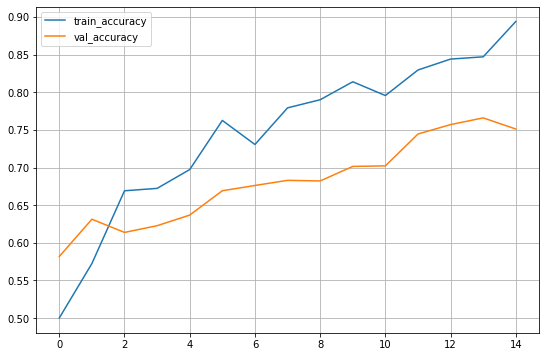

In [51]:
plt.figure(figsize=(9, 6))
plt.plot([-x for x in tab_net.history['train']['metric']], label='train_accuracy')
plt.plot([-x for x in tab_net.history['valid']['metric']], label='val_accuracy')
plt.legend()
plt.grid()
plt.show()

In [54]:
test = pd.read_csv("test.csv", header=None)
y_prob = tab_net.predict_proba(test[features].values)[:,1]
y_pred = np.where(y_prob > 0.5, 1, 0)

In [56]:
submit = pd.DataFrame(y_pred)
submit.index += 1
submit.columns = ['Solution']
submit['Id'] = np.arange(1, submit.shape[0]+1)
submit = submit[['Id', 'Solution']]
submit.to_csv('Submission_tabnet.csv', index=False)